# Property Class Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

import json
from pymongo import MongoClient
from bson.objectid import ObjectId

import pickle

import pickle

In [47]:
# Import cleaned listing data

client = MongoClient()
db = client.property_investor
listings = db.listings
cursor = listings.find({'state': 'MN'})
df = pd.DataFrame(list(cursor))

print(df.shape)
df.head()
    

(90, 33)


,_id,address,annual_income,baths,beds,city,cluster,cost_square_feet,days_on_market,description_text,...,state,unit_1_beds,unit_2_beds,unit_3_beds,unit_4_beds,unit_rent,url,year_built,year_built_adjusted,zip
0,58b5f1b0dcc9d8d448be2325,3039 Bryant Ave S,85440.0,1.0,4.0,Minneapolis,7.0,174.0,1.0,Great investment opportunity in the heart of U...,...,MN,1.0,1.0,1.0,1.0,775.0,http://www.redfin.com/MN/Minneapolis/3039-Brya...,1913.0,63.0,55408
1,58b5f1b0dcc9d8d448be2326,3307 29th Ave S,19704.0,2.0,3.0,Minneapolis,2.0,123.0,1.0,"New windows, siding, foundation, updated bathr...",...,MN,2.0,1.0,NaN,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3307-29th...,1900.0,50.0,55406
2,58b5f1b0dcc9d8d448be2328,3540 Bloomington Ave,74112.0,1.0,8.0,Minneapolis,0.0,59.0,3.0,"great investment property , great location. Cu...",...,MN,2.0,2.0,2.0,2.0,NaN,http://www.redfin.com/MN/Minneapolis/3540-Bloo...,1928.0,78.0,55407
3,58b5f1b0dcc9d8d448be2329,3028 Fillmore St NE,60480.0,3.0,5.0,Minneapolis,8.0,125.0,3.0,Beautiful Audobon Park duplex that is owner oc...,...,MN,3.0,2.0,1.0,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3028-Fill...,1935.0,85.0,55418
4,58b5f1b0dcc9d8d448be232a,3945 Van Nest Ave,49536.0,1.0,3.0,Minneapolis,1.0,120.0,3.0,This classic Minneapolis duplex is filled with...,...,MN,1.0,1.0,1.0,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3945-Van-...,1891.0,41.0,55409


In [119]:
subset = ['rent_index', 'cluster', 'year_built_adjusted']

In [120]:
subset_df = df[subset].copy(deep=True)
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
rent_index             90 non-null float64
cluster                53 non-null float64
year_built_adjusted    90 non-null float64
dtypes: float64(3)
memory usage: 2.2 KB


In [121]:
subset_df = subset_df.dropna()
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 52
Data columns (total 3 columns):
rent_index             53 non-null float64
cluster                53 non-null float64
year_built_adjusted    53 non-null float64
dtypes: float64(3)
memory usage: 1.7 KB


In [113]:
# cluster_df['state'].value_counts()

In [156]:
scale = StandardScaler()
cluster_df = pd.DataFrame(scale.fit_transform(subset_df), columns = subset)
cluster_df.head()

,rent_index,cluster,year_built_adjusted
0,2.450613,1.159969,-0.022892
1,-2.456712,-0.761229,-0.515785
2,-0.483155,-1.529709,0.545831
3,-0.263028,1.544208,0.811234
4,0.651640,-1.145469,-0.857018


In [131]:
subset_data = np.array(subset_df.values)

In [141]:
data_scale = scale.fit(subset_data)
data = data_scale.transform(subset_data)

In [69]:
print(cluster_df['rent_index'].describe())
print('\n')
print(cluster_df['cluster'].describe())
print('\n')
print(cluster_df['year_built_adjusted'].describe())

count    53.000000
mean      0.893686
std       0.164709
min       0.492879
25%       0.814861
50%       1.000000
75%       1.000000
max       1.293498
Name: rent_index, dtype: float64


count    53.000000
mean      3.981132
std       2.627448
min       0.000000
25%       2.000000
50%       3.000000
75%       7.000000
max       9.000000
Name: cluster, dtype: float64


count     53.000000
mean      63.603774
std       26.627299
min       37.000000
25%       50.000000
50%       52.000000
75%       65.000000
max      156.000000
Name: year_built_adjusted, dtype: float64


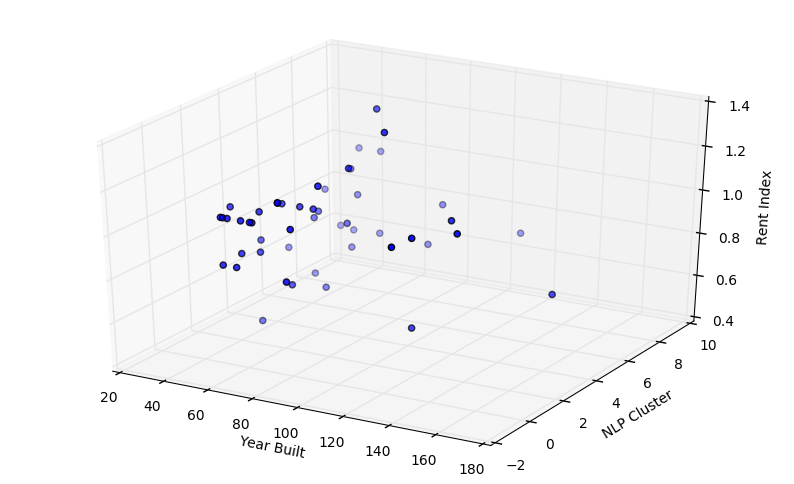

In [230]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111, projection='3d')

xs = subset_df['year_built_adjusted']
ys = subset_df['cluster']
zs = subset_df['rent_index']
ax.scatter(xs, ys, zs)

ax.set_xlabel('Year Built')
ax.set_ylabel('NLP Cluster')
ax.set_zlabel('Rent Index')

plt.show()

In [57]:
# Collect best model silhouette scores
best_scores = {}

In [71]:
from sklearn.cluster import KMeans

Inertia = []
Sil_coefs = []

for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(data_scale)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(data_scale, labels, metric='euclidean'))
    Inertia.append(km.inertia_)

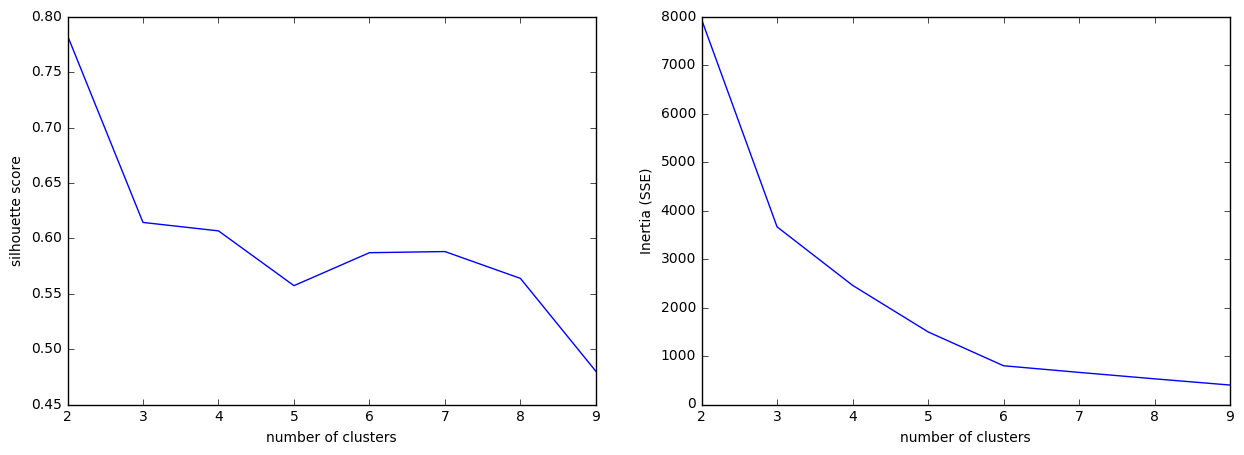

In [159]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette score')

# plot here on ax2
ax2.plot(k_clusters, Inertia)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia (SSE)');

In [164]:
km = KMeans(n_clusters=6, random_state=1)
km.fit(cluster_df)

km_core_samples_mask = np.zeros_like(km.labels_, dtype=bool)
km_labels = km.labels_

# Number of clusters in labels, ignoring noise if present.
km_n_clusters_ = len(set(km_labels))
km_silhouette = metrics.silhouette_score(cluster_df, km_labels)

print('Estimated number of clusters: %d' % km_n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % km_silhouette)

Estimated number of clusters: 6
Silhouette Coefficient: 0.438


In [165]:
# Add best Kmeans model score to best_scores dict

best_scores['Kmeans'] = {}
best_scores['Kmeans']['clusters'] = km_n_clusters_
best_scores['Kmeans']['score'] = km_silhouette

best_scores

{'Agglomerative': {'clusters': 3, 'score': 0.61444353800398177},
 'Kmeans': {'clusters': 6, 'score': 0.43780945178168645}}

In [167]:
clusters = km.predict(cluster_df)

from collections import Counter
Counter(clusters)

Counter({0: 21, 1: 10, 2: 4, 3: 13, 4: 2, 5: 3})

In [65]:
# for i, row in df.iterrows():
#     df.loc[i, 'km'] = clusters[i]

In [66]:
# print(df['km'].value_counts())
# df.head()

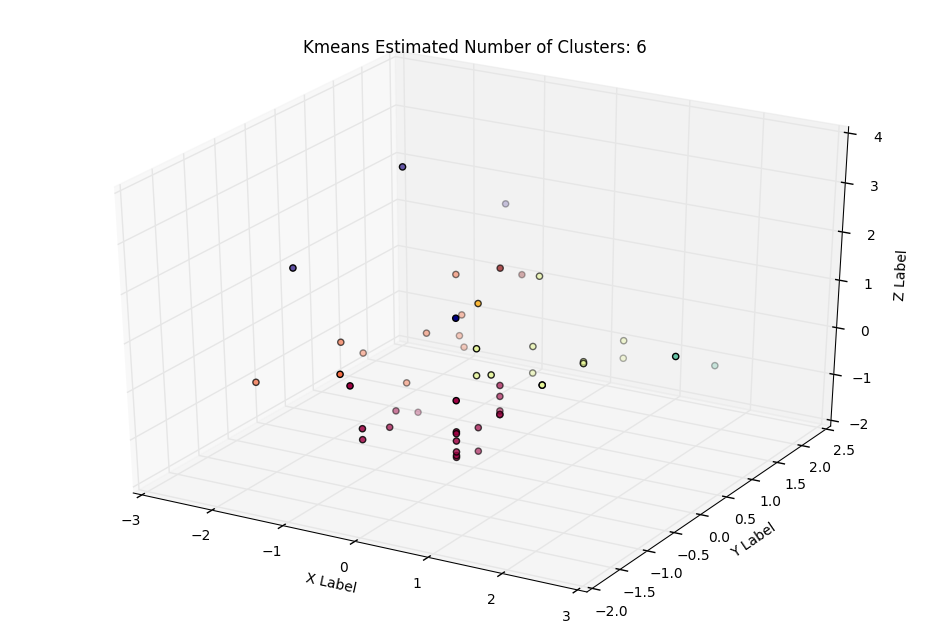

In [168]:
core_samples_mask = np.zeros_like(km.labels_, dtype=bool)
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')

# Black removed and is used for noise instead.
unique_labels = set(km_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    class_member_mask = (km_labels == k)
    xyz = data[class_member_mask & core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', c=col)

    xyz = data[class_member_mask & ~core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', c=col)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Kmeans Estimated Number of Clusters: %d' % km_n_clusters_)
plt.show()

## AgglomerativeClustering

In [171]:
from sklearn.cluster import AgglomerativeClustering

Sil_coefs = []

for k in range(2,10):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(cluster_df)
    labels = agg.labels_
    Sil_coefs.append(metrics.silhouette_score(cluster_df, labels, metric='euclidean'))

In [172]:
Sil_coefs

[0.29730908614328433,
 0.3604091665287687,
 0.3953769337112924,
 0.40721743197163046,
 0.42709466973636917,
 0.44895698365090431,
 0.44392972619240778,
 0.41899200138456555]

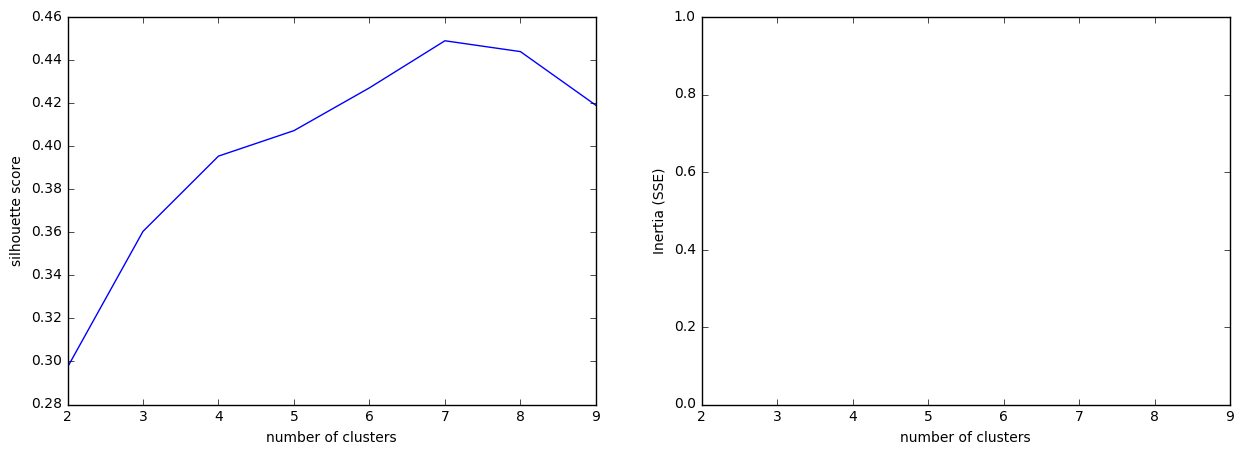

In [173]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette score')

# plot here on ax2
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia (SSE)');

In [175]:
agg = AgglomerativeClustering(n_clusters=7, linkage='ward')
agg.fit(cluster_df)

agg_core_samples_mask = np.zeros_like(agg.labels_, dtype=bool)
agg_labels = agg.labels_

# Number of clusters in labels, ignoring noise if present.
agg_n_clusters_ = len(set(agg_labels))
agg_silhouette = metrics.silhouette_score(cluster_df, agg_labels)

print('Estimated number of clusters: %d' % agg_n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % agg_silhouette)

Estimated number of clusters: 7
Silhouette Coefficient: 0.449


In [176]:
# Add best Agglomerative model score to best_scores dict

best_scores['Agglomerative'] = {}
best_scores['Agglomerative']['clusters'] = agg_n_clusters_
best_scores['Agglomerative']['score'] = agg_silhouette

best_scores

{'Agglomerative': {'clusters': 7, 'score': 0.44895698365090431},
 'Kmeans': {'clusters': 6, 'score': 0.43780945178168645}}

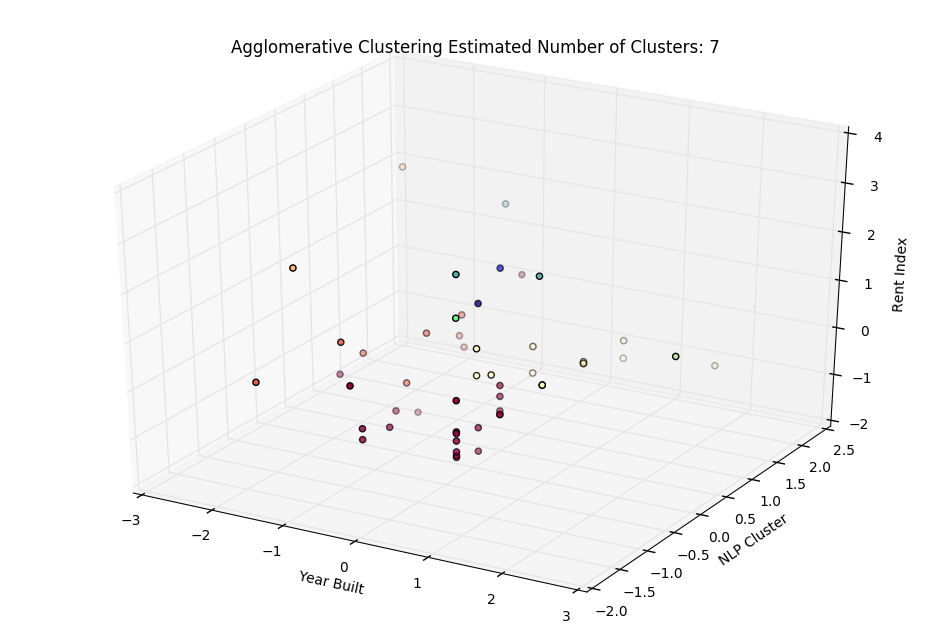

In [228]:
core_samples_mask = np.zeros_like(agg.labels_, dtype=bool)
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')

# Black removed and is used for noise instead.
unique_labels = set(agg_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):

    class_member_mask = (agg_labels == k)

    xyz = data[class_member_mask & core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', c=col)

    xyz = data[class_member_mask & ~core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', c=col)

ax.set_xlabel('Year Built')
ax.set_ylabel('NLP Cluster')
ax.set_zlabel('Rent Index')
plt.title('Agglomerative Clustering Estimated Number of Clusters: %d' % agg_n_clusters_)
plt.show()

## SpectralClustering

In [178]:
from sklearn.cluster import SpectralClustering

In [183]:
Sil_coefs = []

for k in range(2,10):
    spec = SpectralClustering(n_clusters=k, eigen_solver=None, random_state=42, n_init=10, gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol=0.0, assign_labels='kmeans', kernel_params=None, n_jobs=-1)
    spec.fit(cluster_df)
    spec_labels = spec.labels_
    Sil_coefs.append(metrics.silhouette_score(cluster_df, spec_labels, metric='euclidean'))

In [184]:
Sil_coefs

[0.25641062326115482,
 0.29918861401339458,
 0.31419626823728702,
 0.33909561343524397,
 0.29962923412164638,
 0.32592542025836008,
 0.30240319028915386,
 0.31193719455770214]

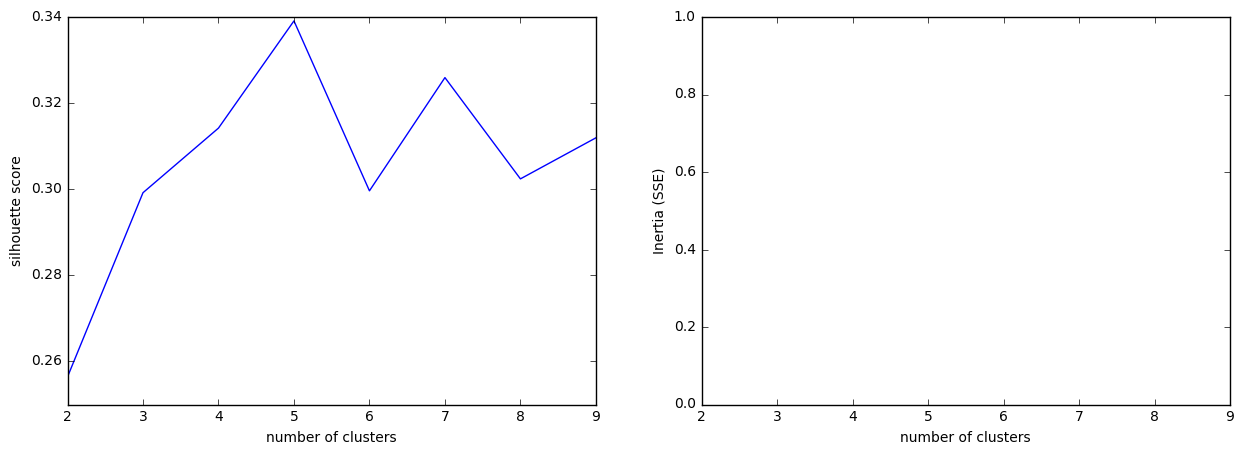

In [186]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette score')

# plot here on ax2
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia (SSE)');

In [192]:
# Best Model
spec = SpectralClustering(n_clusters=5, eigen_solver=None, random_state=42, n_init=10, gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol=0.0, assign_labels='kmeans', kernel_params=None, n_jobs=-1)
spec.fit(cluster_df)

spec_core_samples_mask = np.zeros_like(spec.labels_, dtype=bool)
spec_labels = spec.labels_

spec_n_clusters_ = len(set(spec_labels))
spec_silhouette = metrics.silhouette_score(cluster_df, spec_labels)

print('Estimated number of clusters: %d' % spec_n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % spec_silhouette)

Estimated number of clusters: 5
Silhouette Coefficient: 0.339


In [193]:
# Add best Agglomerative model score to best_scores dict

best_scores['Spectral'] = {}
best_scores['Spectral']['clusters'] = spec_n_clusters_
best_scores['Spectral']['score'] = spec_silhouette

best_scores

{'Agglomerative': {'clusters': 7, 'score': 0.44895698365090431},
 'Kmeans': {'clusters': 6, 'score': 0.43780945178168645},
 'Spectral': {'clusters': 5, 'score': 0.33909561343524397}}

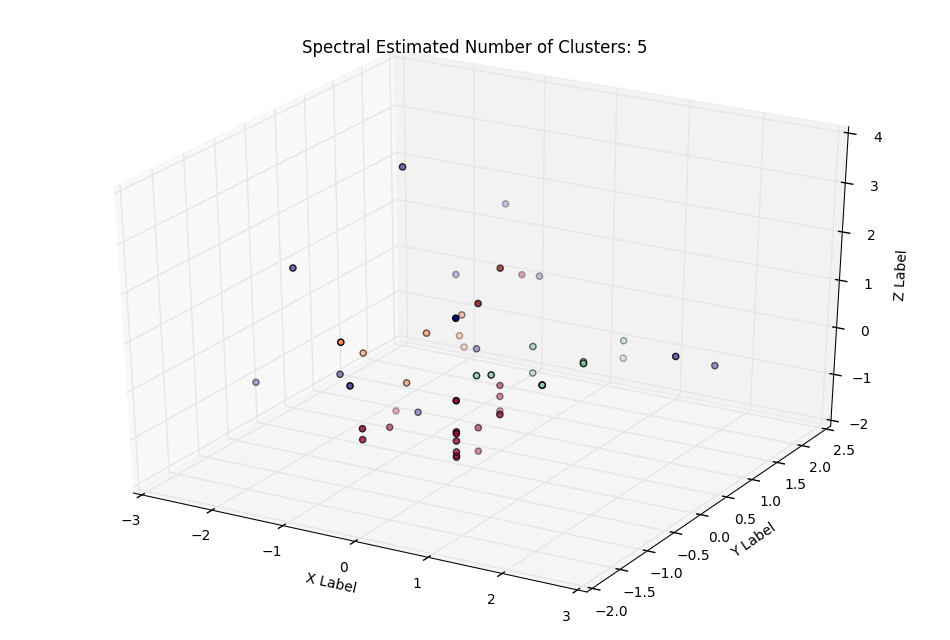

In [194]:
# Number of clusters in labels, ignoring noise if present.


fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')

unique_labels = set(spec_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):

    class_member_mask = (spec_labels == k)

    xyz = data[class_member_mask & core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', c=col)

    xyz = data[class_member_mask & ~core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', c=col)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Spectral Estimated Number of Clusters: %d' % spec_n_clusters_)
plt.show()

## DBSCAN

In [196]:
from sklearn.cluster import DBSCAN

In [207]:
dbsc = DBSCAN(eps=0.5, min_samples=3, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=1)
dbsc.fit(cluster_df)
dbsc_labels = dbsc.labels_

# Number of clusters in labels, ignoring noise if present.
dbsc_n_clusters_ = len(set(dbsc_labels)) - (1 if -1 in dbsc_labels else 0)
dbsc_silhouette = metrics.silhouette_score(cluster_df, dbsc_labels)

print('Estimated number of clusters: %d' % dbsc_n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % dbsc_silhouette )


Estimated number of clusters: 4
Silhouette Coefficient: 0.088


In [208]:
# Add best DBSCAN model score to best_scores dict

best_scores['DBSCAN'] = {}
best_scores['DBSCAN']['clusters'] = dbsc_n_clusters_
best_scores['DBSCAN']['score'] = dbsc_silhouette

best_scores

{'Agglomerative': {'clusters': 7, 'score': 0.44895698365090431},
 'DBSCAN': {'clusters': 4, 'score': 0.088391329729108112},
 'Kmeans': {'clusters': 6, 'score': 0.43780945178168645},
 'Spectral': {'clusters': 5, 'score': 0.33909561343524397}}

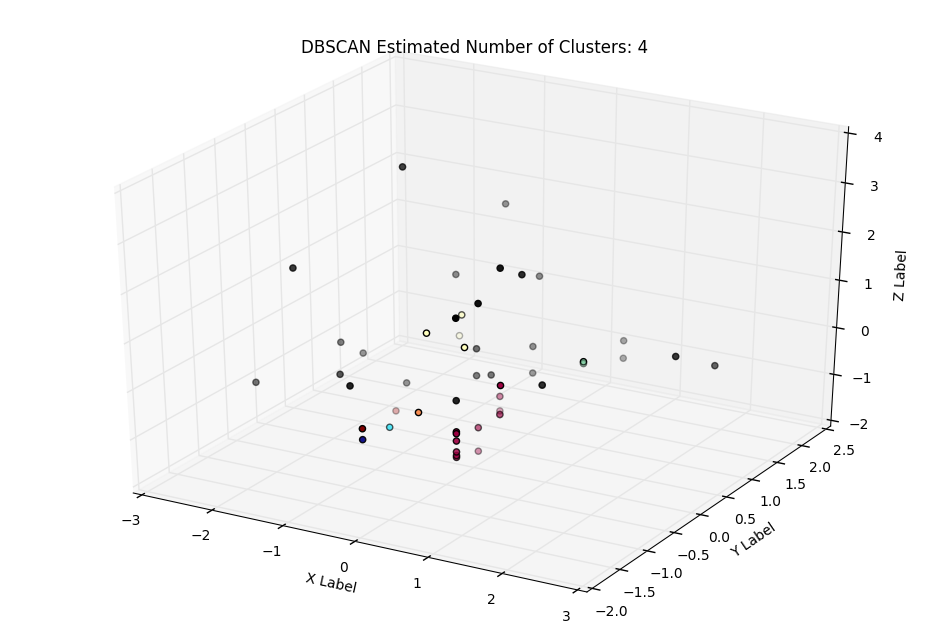

In [209]:
# 3D Plot DBSCAN clusters

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')

# Black removed and is used for noise instead.
core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
dbsc_unique_labels = set(dbsc_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(dbsc_unique_labels)))
for k, col in zip(dbsc_unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (dbsc_labels == k)

    xyz = data[class_member_mask & core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', c=col)

    xyz = data[class_member_mask & ~core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], '^', c=col)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('DBSCAN Estimated Number of Clusters: %d' % dbsc_n_clusters_)
plt.show()

## Mean Shift

In [211]:
from sklearn.cluster import MeanShift

In [213]:
ms = MeanShift(bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, n_jobs=-1)
ms.fit(cluster_df)
ms_labels = dbsc.labels_

# Number of clusters in labels, ignoring noise if present.
ms_n_clusters_ = len(set(ms_labels)) - (1 if -1 in ms_labels else 0)
ms_silhouette = metrics.silhouette_score(cluster_df, ms_labels)

print('Estimated number of clusters: %d' % ms_n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % ms_silhouette )

Estimated number of clusters: 4
Silhouette Coefficient: 0.088


In [214]:
# Add best DBSCAN model score to best_scores dict

best_scores['Mean Shift'] = {}
best_scores['Mean Shift']['clusters'] = ms_n_clusters_
best_scores['Mean Shift']['score'] = ms_silhouette

best_scores

{'Agglomerative': {'clusters': 7, 'score': 0.44895698365090431},
 'DBSCAN': {'clusters': 4, 'score': 0.088391329729108112},
 'Kmeans': {'clusters': 6, 'score': 0.43780945178168645},
 'Mean Shift': {'clusters': 4, 'score': 0.088391329729108112},
 'Spectral': {'clusters': 5, 'score': 0.33909561343524397}}

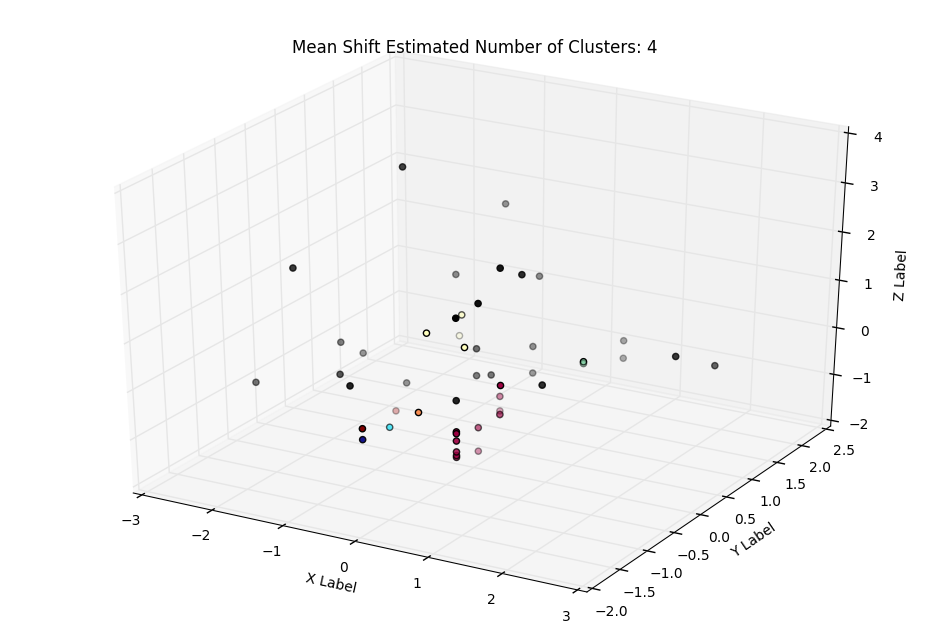

In [218]:
# 3D Plot Mean Shift clusters

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')

# Black removed and is used for noise instead.
core_samples_mask = np.zeros_like(ms.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
ms_unique_labels = set(ms_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(ms_unique_labels)))
for k, col in zip(ms_unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (dbsc_labels == k)

    xyz = data[class_member_mask & core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', c=col)

    xyz = data[class_member_mask & ~core_samples_mask]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], '^', c=col)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Mean Shift Estimated Number of Clusters: %d' % ms_n_clusters_)
plt.show()

## Best Scores

In [226]:
best_scores_df = pd.DataFrame.from_dict(best_scores, orient='index')
best_scores_df.sort_values('score', ascending=False)

,clusters,score
Agglomerative,7,0.448957
Kmeans,6,0.437809
Spectral,5,0.339096
DBSCAN,4,0.088391
Mean Shift,4,0.088391


In [231]:
import seaborn as sns

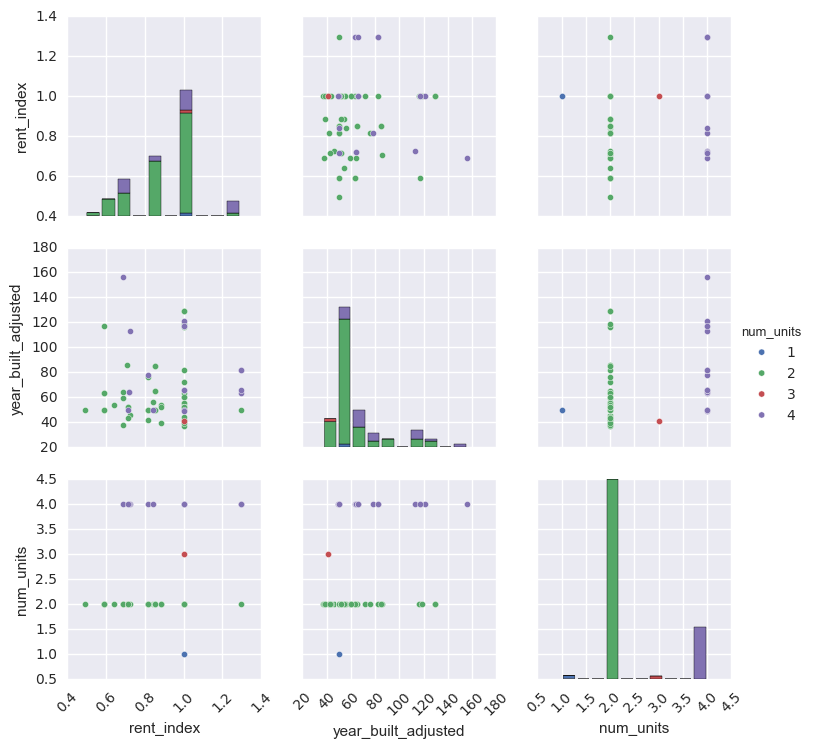

In [233]:
g = sns.pairplot(df[['rent_index','year_built_adjusted', 'num_units']], hue="num_units", diag_kind="hist")  
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)